# Baseline Models for recommendation

## Library Imports

In [2]:
from datetime import datetime, timedelta
import random
import json
import statistics
import re
from typing import Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import surprise
import implicit
import nltk
from nltk.corpus import stopwords
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.linear_model import SGDRegressor
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm.notebook import tqdm_notebook

tqdm_notebook().pandas()


0it [00:00, ?it/s]

## Loading the data

In [3]:
user_df = pd.read_csv("./columns_removed/users.csv", index_col="Unnamed: 0")
account_user_df = pd.read_csv(
    "./columns_removed/account_users.csv", index_col="Unnamed: 0"
)

service_subscripted_df = pd.read_csv(
    "./columns_removed/service_subscripted.csv", index_col="Unnamed: 0"
)
service_subscripted_mode_df = pd.read_csv(
    "./columns_removed/service_subscripted_modes.csv", index_col="Unnamed: 0"
)
service_subscripted_status_df = pd.read_csv(
    "./columns_removed/service_subscripted_status.csv", index_col="Unnamed: 0"
)

service_df = pd.read_csv("./columns_removed/services.csv", index_col="Unnamed: 0")
service_category_df = pd.read_csv(
    "./columns_removed/service_categories.csv", index_col="Unnamed: 0"
)
service_class_df = pd.read_csv(
    "./columns_removed/service_classes.csv", index_col="Unnamed: 0"
)
service_price_df = pd.read_csv(
    "./columns_removed/service_prices.csv", index_col="Unnamed: 0"
)


In [4]:
service_subscripted_df.shape


(2354, 30)

We have just 2354 transactions of data. This is pretty small.

### Parsing the related data
The related data comes as an object, we have to parse it, to get just the ID so we can join later on
- The related columns in the data contain objects with the related data type, and the object id.
- We create methods to extract the ID (or list of IDs) and replace in the data for more data manipulation

In [5]:
def getObjectId(string):
    return (
        json.loads(string.replace("'", '"'))["objectId"]
        if type(string) == str
        else None
    )


In [6]:
def getObjectIds(strings):
    strings = json.loads(strings.replace("'", '"')) if type(strings) == str else None
    return [string["objectId"] for string in strings] if not strings is None else None


In [7]:
print("Extracting IDs in service_subscripted_df")
service_subscripted_df["user"] = service_subscripted_df["user"].progress_apply(
    getObjectId
)
service_subscripted_df["service"] = service_subscripted_df["service"].progress_apply(
    getObjectId
)
service_subscripted_df["servicePrice"] = service_subscripted_df[
    "servicePrice"
].progress_apply(getObjectId)
service_subscripted_df["serviceSubscriptedStatus"] = service_subscripted_df[
    "serviceSubscriptedStatus"
].progress_apply(getObjectId)


Extracting IDs in service_subscripted_df


  0%|          | 0/2354 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

In [8]:
service_subscripted_df[
    ["user", "service", "servicePrice", "serviceSubscriptedStatus"]
].head()


,user,service,servicePrice,serviceSubscriptedStatus
0,Wuht2SEQKc,7m30TaadKw,7IQOMYgNjp,tW5G9aXwir
1,Wuht2SEQKc,7m30TaadKw,9ZSLOxD6Qe,tW5G9aXwir
2,Wuht2SEQKc,AuoUzp7zT5,9ZSLOxD6Qe,tW5G9aXwir
3,Wuht2SEQKc,AuoUzp7zT5,7IQOMYgNjp,tW5G9aXwir
4,Wuht2SEQKc,ftB5W0yalq,9ZSLOxD6Qe,tW5G9aXwir


In [9]:
print("Extracting IDs in service_df")
service_df = pd.read_csv("./columns_removed/services.csv", index_col="Unnamed: 0")
service_df["servicePrices"] = service_df["servicePrices"].progress_apply(getObjectIds)
service_df["serviceCategories"] = service_df["serviceCategories"].progress_apply(
    getObjectIds
)


Extracting IDs in service_df


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

In [10]:
service_df[["servicePrices", "serviceCategories"]].head()


,servicePrices,serviceCategories
0,"[S7143GMweM, 4Q1ZU3K9JG, kqjeGDDnok, niCzqvNs2...","[EpKYNatgiA, 1pSekv8tDk]"
1,"[niCzqvNs2p, kqjeGDDnok, udbz7SmUsG, cBoebS59t...","[0wvHuyIHIc, EpKYNatgiA]"
2,"[S7143GMweM, 4Q1ZU3K9JG, kqjeGDDnok, niCzqvNs2...","[Y75plfloDh, 3qMFRyth3m]"
3,"[niCzqvNs2p, kqjeGDDnok, WyRlkmAw6G, SykQsRCcZ...",[1pSekv8tDk]
4,"[niCzqvNs2p, kqjeGDDnok, WyRlkmAw6G, SykQsRCcZ...",[1pSekv8tDk]


## Splitting the train and test data

- We will order our transactions.
- We then split them to leave a section of the later transactions out as our test set.
- Our model is evaluated on the test to verify if the model, would have gotten their purchases correct.

In [11]:
service_subscripted_df["createdAt"] = pd.to_datetime(
    service_subscripted_df["createdAt"]
)
service_subscripted_df = service_subscripted_df.sort_values(by="createdAt")
service_subscripted_df[["objectId", "user", "service", "createdAt"]].head()


,objectId,user,service,createdAt
0,CKaeuDD4Pz,Wuht2SEQKc,7m30TaadKw,2018-06-14 16:45:08.861000+00:00
1,BF71jBseqP,Wuht2SEQKc,7m30TaadKw,2018-06-14 16:47:09.686000+00:00
2,p28B1oCABN,Wuht2SEQKc,AuoUzp7zT5,2018-06-14 16:58:07.494000+00:00
3,hngNyfZy40,Wuht2SEQKc,AuoUzp7zT5,2018-06-14 17:01:02.038000+00:00
4,MNLGJSLQU3,Wuht2SEQKc,ftB5W0yalq,2018-06-14 18:42:27.391000+00:00


In [12]:
print(service_subscripted_df["createdAt"].dtype)
earliest_date: datetime = service_subscripted_df.iloc[0, 10]
latest_date: datetime = service_subscripted_df.iloc[-1, 10]
time_difference = latest_date - earliest_date
print("The earliest date is: {}".format(earliest_date))
print("The latest date is: {}\n".format(latest_date))
print("The timespan of the dataset is: {} days".format(time_difference.days))


datetime64[ns, UTC]
The earliest date is: 2018-06-14 16:45:08.861000+00:00
The latest date is: 2021-03-22 15:36:05.046000+00:00

The timespan of the dataset is: 1011 days


The timespan corresponds to about 3 years. This means that we can consider the test set as the last year of the data while we train on the first two years.

- The train set will be the first 24 months: `24 x 30 = 720` days
- The test set will be the rest

In [13]:
training_split_date: datetime = earliest_date + timedelta(days=720)
train_set = service_subscripted_df[
    service_subscripted_df["createdAt"] < training_split_date
]
test_set = service_subscripted_df[
    service_subscripted_df["createdAt"] >= training_split_date
]


In [14]:
train_set[["objectId", "user", "service", "createdAt"]].head()


,objectId,user,service,createdAt
0,CKaeuDD4Pz,Wuht2SEQKc,7m30TaadKw,2018-06-14 16:45:08.861000+00:00
1,BF71jBseqP,Wuht2SEQKc,7m30TaadKw,2018-06-14 16:47:09.686000+00:00
2,p28B1oCABN,Wuht2SEQKc,AuoUzp7zT5,2018-06-14 16:58:07.494000+00:00
3,hngNyfZy40,Wuht2SEQKc,AuoUzp7zT5,2018-06-14 17:01:02.038000+00:00
4,MNLGJSLQU3,Wuht2SEQKc,ftB5W0yalq,2018-06-14 18:42:27.391000+00:00


## Grouping and Joining the data

- We join the service_subscripted_df with the service_df to get the service information.
- Before joining, we group by user and service to get the number of times a user has subscribed to a product.

In [15]:
train_subscribe_count = train_set.groupby(["user", "service"], as_index=False).size()
test_subscribe_count = test_set.groupby(["user", "service"], as_index=False).size()

train_subscribe_count.head()


,user,service,size
0,0ULHUAAtf3,07s0zeZYjN,53
1,0ULHUAAtf3,1VPS3tlcBE,3
2,0ULHUAAtf3,1wjtGuM9P1,10
3,0ULHUAAtf3,2TklcqXBtG,1
4,0ULHUAAtf3,41SOBgfSTA,8


In [16]:
train_data = train_subscribe_count[["user", "service", "size"]].join(
    service_df[
        [
            "objectId",
            "serviceCategories",
            "servicePrices",
            "name",
            "task_name",
            "keywordServiceCategories",
            "description",
            "haveAndroidApp",
            "haveIOSApp",
        ]
    ].set_index("objectId"),
    on="service",
    how="left",
)

test_data = test_subscribe_count[["user", "service", "size"]].join(
    service_df[
        [
            "objectId",
            "serviceCategories",
            "servicePrices",
            "name",
            "task_name",
            "keywordServiceCategories",
            "description",
            "haveAndroidApp",
            "haveIOSApp",
        ]
    ].set_index("objectId"),
    on="service",
    how="left",
)


In [17]:
train_data.head()


,user,service,size,serviceCategories,servicePrices,name,task_name,keywordServiceCategories,description,haveAndroidApp,haveIOSApp
0,0ULHUAAtf3,07s0zeZYjN,53,None,None,Domain Name,dns,NaN,The Domain Name System (DNS) is a hierarchical...,NaN,NaN
1,0ULHUAAtf3,1VPS3tlcBE,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0ULHUAAtf3,1wjtGuM9P1,10,[1pSekv8tDk],"[niCzqvNs2p, kqjeGDDnok, WyRlkmAw6G, SykQsRCcZ...",Drupal,drupal,"['content', 'management', 'system']","Drupal is a popular CMS software, based on har...",False,False
3,0ULHUAAtf3,2TklcqXBtG,1,"[Y75plfloDh, 3qMFRyth3m]","[niCzqvNs2p, kqjeGDDnok, udbz7SmUsG, cBoebS59t...",MediaWiki,mediawiki,"['software', 'development', 'devops', 'tool']",MediaWiki is a collaboration and documentation...,False,False
4,0ULHUAAtf3,41SOBgfSTA,8,[HMFAL7N1yK],"[prBlW9GMpA, CuYOUoKqX0, 0eSSww5jud, yMmOf4BEC...",Virtual Private Server,vps,"['virtual', 'private', 'server']",Vps description,NaN,NaN


In [18]:
train_data[train_data["user"] == "Wuht2SEQKc"][["service", "size"]].sort_values(
    by="size", ascending=False
).head()


,service,size
195,07s0zeZYjN,103
219,Nd3our0ZjN,55
199,41SOBgfSTA,42
207,AuoUzp7zT5,26
198,2TklcqXBtG,16


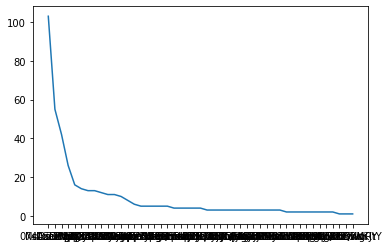

In [19]:
test_user = train_data[train_data["user"] == "Wuht2SEQKc"][
    ["service", "size"]
].sort_values(by="size", ascending=False)
plt.plot(test_user["service"].values, test_user["size"])


The user with that particular ID has used multiple services a certain number of times. This will count as our implicit feedback

The number of times a user has subscribed to a particular services seems to be exponential.

In [20]:
train_data[train_data["service"] == "07s0zeZYjN"][["user", "size"]].sort_values(
    by="size", ascending=False
).head()


,user,size
195,Wuht2SEQKc,103
0,0ULHUAAtf3,53
67,4J60SXAGWB,50
136,JVEJq4hHlI,42
260,jzl9egzBnk,15


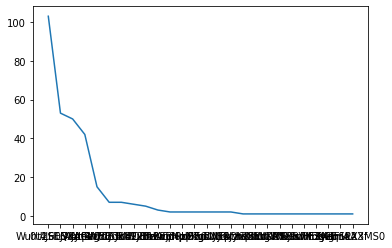

In [21]:
test_service = train_data[train_data["service"] == "07s0zeZYjN"][
    ["user", "size"]
].sort_values(by="size", ascending=False)
plt.plot(test_service["user"].values, test_service["size"].values)


The curve for the number of times a service has been used has a similar shape

## Evaluation functions

### Recall at N

For $N$ items recommended to a user, let $m$ be the number of relevant items in the list of $N$ items recommended and $M$ be the total number of relevant items. We have the **recall at N** to be,
$
recall\ at\ N = \frac m M
$

In [22]:
def recall_at_N(rankings: Dict[str, list], test_count: pd.DataFrame, N: int = 20):
    recall_sum = 0
    for user in rankings.keys():
        recommendations = rankings[user][
            :N
        ]  # We get the first N items from the ranked list
        relevant_items: list = (
            test_count[test_count["user"] == user]
            .sort_values(by="size", ascending=False)["service"]
            .values
        )
        relevant_recommendations = list(set(recommendations) & set(relevant_items))
        recall = len(relevant_recommendations) / len(relevant_items)
        recall_sum += recall

    mean_recall = recall_sum / len(rankings.keys())
    return mean_recall * 100


### Rank

This is a measure that takes into account the order in which the items have been recommended.

We denote by $rank_{ui}$ the percentile rank of the item $i$ within the ordered list of all items prepared for user $u$. 

This implies that $rank_{ui} = 0\%$ would mean item $i$ is predicted to be the most desirable for user $u$ being in the first position.

On the other hand, $rank_{ui} = 100\%$ means item $i$ is predicted to be the least desirable for user $u$ being in the last position.

Percentile ranks instead of absolute ranks are used to make sure the score is independent of the number of items, which is variable.

The measure is basically the expected percentile ranking of an item during the test period.

Let $r_{ui}^t$ be the rating of item $i$ for user $u$ during the test period. Then the measure is calculated as follows:

$
rank = \frac {\sum_{ui} r_{ui}^t rank_{ui}} {\sum_{ui} r_{ui}^t}
$

We will use a modified version to compute the rank_score at $N$. We will calculate the expected percentile ranking of items only in the first $N$ ranked items.

In [23]:
def rank_score(rankings: Dict[str, list], test_count: pd.DataFrame, N: int = 20):
    rank_sum = 0
    rating_sum = 0
    for user in rankings.keys():
        # print(len(rankings[user]))
        for (index, item) in enumerate(rankings[user]):
            if index >= N:
                break
            rank_ui: float = (index / len(rankings[user])) * 100
            rating_ui: int = test_count[
                (test_count["user"] == user) & (test_count["service"] == item)
            ]["size"].values
            if len(rating_ui) <= 0:
                rating_ui = 0
            else:
                rating_ui = rating_ui[0]
            rank_sum += rank_ui * rating_ui
            rating_sum += rating_ui

    expected_rank = rank_sum / rating_sum
    return expected_rank


## Reading data

In [24]:
reader = surprise.Reader(rating_scale=(0, 103))
train_dataset = surprise.Dataset.load_from_df(
    train_data[["user", "service", "size"]], reader
)


## Baseline Models

### Base Model

We start by defining a base Model that has functions for instanciating and evaluating the models. Any other functions common to all models will be put here.

In [25]:
class BaseModel:
    def __init__(self, train_count: pd.DataFrame, test_count: pd.DataFrame):
        self.train_count = train_count
        self.test_count = test_count
        self.rankings = None

    def rank_items(self):
        pass

    def evaluate_recall(self, rankings: Dict[str, list], N: int = 20, on_train: bool = False):
        if rankings is None:
            raise Exception("Rankings cannot be None")
        else:
            return recall_at_N(rankings=rankings, test_count=self.train_count if on_train else self.test_count, N=N)

    def evaluate_rank(self, rankings: Dict[str, list], on_train: bool = False, N: int = 20):
        if rankings is None:
            raise Exception("Rankings cannot be None")
        else:
            return rank_score(rankings=rankings, test_count=self.train_count if on_train else self.test_count, N=N)


### Random model

This model randomly recommends $N$ items to each of the users.

#### Building the model

In [26]:
class RandomModel(BaseModel):
    def rank_items(self):
        users = self.train_count["user"].unique()
        items = self.train_count["service"].unique()
        rankings: Dict[str, list] = {}
        for user in users:
            random.shuffle(items)
            rankings[user] = items
        return rankings


In [27]:
class SurpriseRandomModel(surprise.NormalPredictor):
    def rank_items(self, users: list, items: list):
        rankings: Dict[str, list] = {}
        for user in users:
            ranking_list = [self.predict(user, item, clip=False) for item in items]
            rankings_df = pd.DataFrame({"item": items, "ranking": ranking_list})
            rankings[user] = rankings_df.sort_values(by="ranking")["item"].values
        return rankings


#### Evaluating the model

In [28]:
random_model = RandomModel(train_count=train_data, test_count=test_data)
surprise_random_model = SurpriseRandomModel()
surprise_random_model.fit(train_dataset.build_full_trainset())
random_rankings = random_model.rank_items()
surprise_random_rankings = surprise_random_model.rank_items(
    users=train_data["user"].unique(), items=train_data["service"].unique()
)


In [29]:
num_services = len(train_data["service"].values)
random_rank_score = random_model.evaluate_rank(
    rankings=random_rankings, on_train=True, N=num_services
)
surprise_random_rank_score = rank_score(
    rankings=surprise_random_rankings, test_count=train_data, N=num_services
)


In [30]:
print("The rank score for the random model is {} %".format(random_rank_score))
print(
    "The rank score for the surprise random model is {} %".format(
        surprise_random_rank_score
    )
)


The rank score for the random model is 55.3912488022996 %
The rank score for the surprise random model is 34.769509208985404 %


The rank score for the random is quite correct, since it is normally supposed to be about 50%

The rank score for the surprise module is lower, possibly due to the fact that it uses a normal distribution.

In [31]:
random_recall = random_model.evaluate_recall(
    rankings=random_rankings, N=40, on_train=True
)
surprise_random_recall = recall_at_N(
    rankings=surprise_random_rankings, N=40, test_count=train_data
)


In [32]:
print("The recall score for the random model is {} %".format(random_recall))
print(
    "The recall score for the surprise random model is {} %".format(
        surprise_random_recall
    )
)


The recall score for the random model is 53.02772840777256 %
The recall score for the surprise random model is 73.79597856738056 %


### Global Popularity based model

This model simply consists of recommending the $N$ most popular items to every user.

#### Building model

In [33]:
class PopularityModel(BaseModel):
    def rank_items(self):
        users = self.train_count["user"].unique()
        global_item_count = (
            self.train_count.groupby(by="service", as_index=False)
            .sum()
            .sort_values(by="size", ascending=False)
        )
        rankings: Dict[str, list] = {}
        for user in users:
            rankings[user] = global_item_count["service"].values
        return rankings


#### Evaluating model

In [34]:
popularity_model = PopularityModel(train_count=train_data, test_count=test_data)
popularity_rankings = popularity_model.rank_items()


In [35]:
num_services = len(train_data["service"].values)
popularity_rank_score = popularity_model.evaluate_rank(
    rankings=popularity_rankings, on_train=True, N=num_services
)


In [36]:
print("The rank score for the popularity model is {} %".format(popularity_rank_score))


The rank score for the popularity model is 16.986053444054086 %


The rank score has improved from the random model which was at about 50% to about 17%

In [37]:
popularity_recall = popularity_model.evaluate_recall(
    rankings=popularity_rankings, N=40, on_train=True
)


In [38]:
print("The recall for the popularity model is {} %".format(popularity_recall))


The recall for the popularity model is 92.70480282918193 %


We see an increase in recall from the random model even thought high recall doesn't necessarily imply a good performing model.

### Global Baseline model

#### Theoritical concept

This model encapsulates all the effects that do not involve user-item interaction.

We denote $\mu$ the overall average. A baseline prediction for an unknown item $i$ by a user $u$ will be denoted by $b_{ui}$ and accounts for the user and the item effects:

$
b_{ui} = \mu + b_u + b_i
$


The parameters $b_u$ and $b_i$ indicate the observed deviations of user $u$ and item $i$ respectively, from the average. In order to estimate $b_u$ and $b_i$, we will solve the least squares problem:
$
\min_{b_*} \sum_{(u, i) \in \Kappa} {(r_{ui} - \mu - b_u - b_i)^2} + \lambda_1(\sum_u {b_u^2} + \sum_i {b_i^2})
$
The regularization term avoids overfitting.

In [39]:
class SurpriseGlobalBaselineModel(surprise.BaselineOnly):
    def rank_items(self, users: list, items: list):
        rankings: Dict[str, list] = {}
        for user in users:
            ranking_list = [self.predict(user, item, clip=False) for item in items]
            rankings_df = pd.DataFrame({"item": items, "ranking": ranking_list})
            rankings[user] = rankings_df.sort_values(by="ranking")["item"].values
        return rankings


#### Evaluating model

In [40]:
global_baseline_model = SurpriseGlobalBaselineModel()
global_baseline_model.fit(train_dataset.build_full_trainset())
global_baseline_rankings = global_baseline_model.rank_items(
    users=train_data["user"].unique(), items=train_data["service"].unique()
)


Estimating biases using als...


In [41]:
num_services = len(train_data["service"].values)
global_baseline_rank_score = rank_score(
    rankings=global_baseline_rankings, test_count=train_data, N=40
)


In [42]:
print(
    "The rank score for the global baseline model is {} %".format(
        global_baseline_rank_score
    )
)


The rank score for the global baseline model is 22.679880388472828 %


This is a slight improvement from the User popularity model above.

In [43]:
global_baseline_recall = recall_at_N(
    rankings=global_baseline_rankings, test_count=train_data, N=40
)


In [44]:
print("The recall for the global baseline model is {} %".format(global_baseline_recall))


The recall for the global baseline model is 73.79597856738056 %


### Testing if order of users and services is the same as the order of their baselines

And also storing the baselines

In [45]:
users: list = train_data["user"].unique()
services: list = train_data["service"].unique()
mean = train_data["size"].mean()

# print(users)
# print(services)

user_index = 5
item_index = 6

item_baseline = global_baseline_model.bi
user_baseline = global_baseline_model.bu

predict1 = global_baseline_model.predict(
    users[user_index], services[item_index], clip=False
)
predict2 = mean + item_baseline[item_index] + user_baseline[user_index]

print(predict1)
print(predict2)


user: 49xBwwcHpk item: 58z2G8LUxk r_ui = None   est = 3.19   {'was_impossible': False}
3.193944011830001


## Collaborative models

### Transforming training data with the baselines (To be used by ALS and Item CF models)

In [46]:
def get_baseline(row, bi: np.ndarray, bu: np.ndarray):
    size = row["size"]
    uid: str = row["user"]
    iid: str = row["service"]
    user_index = users.tolist().index(uid)
    item_index = services.tolist().index(iid)
    return size - mean - bi[item_index] - bu[user_index]


In [47]:
train_data["baseline"] = train_data.apply(
    get_baseline, axis=1, bi=item_baseline, bu=user_baseline
)
train_data[["user", "service", "baseline"]].describe()


,baseline
count,341.000000
mean,-0.668162
std,8.377521
min,-9.218750
25%,-3.590763
50%,-1.948920
75%,-0.434528
max,88.802974


### Building the confidence values with baseline corrected data.
The Collaborative Filtering for Implicit Feedback Datasets paper details how they used ALS for implicit feedback. They made a certain transformation to their data to use in the Alternating Least Square algorithm. The implicit python module, implements this algorithm but requires the confidence values to be calculated prior. The confidence values are derived by a function that strictly increases with $r_{ui}$. One of the functions they used was:
$
c_{ui} = 1 + \alpha r_{ui}
$

In [48]:
alpha = 40
train_data["confidence"] = train_data["baseline"].apply(
    lambda baseline: 1 + (baseline * alpha)
)
train_data[["user", "service", "confidence"]].describe()


,confidence
count,341.000000
mean,-25.726479
std,335.100853
min,-367.750019
25%,-142.630517
50%,-76.956804
75%,-16.381122
max,3553.118975


### Creating index lookup tables for users and items

In [49]:
uid_to_idx = {}
idx_to_uid = {}

iid_to_idx = {}
idx_to_iid = {}

for (index, user) in enumerate(users):
    uid_to_idx[user] = index
    idx_to_uid[index] = user

for (index, item) in enumerate(services):
    iid_to_idx[item] = index
    idx_to_iid[index] = item


### Implicit ALS model

#### Building the sparse matrix for confidence values

In [50]:
cat_type = pd.api.types.CategoricalDtype(categories=users)
rows = train_data.user.astype(cat_type).cat.codes
# Get the associated row indices

cat_type = pd.api.types.CategoricalDtype(categories=services)
cols = train_data.service.astype(cat_type).cat.codes
# Get the associated column indices

confidence = list(train_data.confidence)  # All of our confidence values

confidence_sparse = sparse.csr_matrix(
    (confidence, (rows, cols)), shape=(len(users), len(services))
)


#### Calculating sparsity

In [51]:
matrix_size = (
    confidence_sparse.shape[0] * confidence_sparse.shape[1]
)  # Number of possible interactions in the matrix
num_interactions = len(
    confidence_sparse.nonzero()[0]
)  # Number of items interacted with
sparsity = 100 * (1 - (num_interactions / matrix_size))
sparsity


87.20930232558139

87.2% of the interaction matrix is sparse. For collaborative filtering to work, the maximum sparsity you could get away with would probably be about 99.5% or so. We are well below this, so we should be able to get decent results.

In [52]:
implicit_als_model = implicit.als.AlternatingLeastSquares(
    factors=100, regularization=0.1, iterations=1000
)
implicit_als_model.fit(confidence_sparse.transpose().tocsr())


100%|██████████| 1000/1000 [00:03<00:00, 314.54it/s]


In [53]:
implicit_als_rankings = {}
for (user, index) in uid_to_idx.items():
    rankings = implicit_als_model.rank_items(
        userid=index,
        user_items=confidence_sparse,
        selected_items=list(idx_to_iid.keys()),
        recalculate_user=False,
    )
    # print(rankings)
    implicit_als_rankings[user] = [idx_to_iid[index] for (index, score) in rankings]


In [54]:
num_services = len(train_data["service"].values)
implicit_als_rank_score = rank_score(
    rankings=implicit_als_rankings, test_count=train_data, N=40
)


In [55]:
print(
    "The MPR score for the Implicit ALS model is {} %".format(implicit_als_rank_score)
)


The MPR score for the Implicit ALS model is 10.110513739545999 %


### Normalizing the baseline values
We have to try two versions of normalization for item-based recommendation:
- Normalizing before calculating baselines
- Calculating baselines before normalizing

#### Defining the normalizer class

In [56]:
class Normalizer:
    def __init__(self):
        pass

    def fit(self, values: np.ndarray):
        self.mean = values.mean()
        self.std = values.std()

    def transform(self, values: np.ndarray):
        return (values - self.mean) / self.std

    def fit_transform(self, values: np.ndarray):
        self.fit(values)
        return self.transform(values)

    def inverse(self, values: np.ndarray):
        return (values * self.std) + self.mean


#### Normalizing the data

In [57]:
normalizer = Normalizer()
normalizer.fit(train_data.baseline.values)
train_data["normal_baseline"] = pd.Series(
    normalizer.transform(train_data.baseline.values)
)


In [58]:
train_data[["user", "service", "baseline", "normal_baseline"]].describe()


,baseline,normal_baseline
count,341.000000,3.410000e+02
mean,-0.668162,-3.906943e-18
std,8.377521,1.001470e+00
min,-9.218750,-1.022158e+00
25%,-3.590763,-3.493749e-01
50%,-1.948920,-1.531050e-01
75%,-0.434528,2.792917e-02
max,88.802974,1.069560e+01


In [59]:
normalizer = Normalizer()
normalizer.fit(train_data["size"].values)
train_data["normal"] = pd.Series(normalizer.transform(train_data["size"].values))


In [60]:
train_data[["user", "service", "size", "normal"]].describe()


,size,normal
count,341.000000,3.410000e+02
mean,4.442815,6.251109e-17
std,9.445219,1.001470e+00
min,1.000000,-3.650391e-01
25%,1.000000,-3.650391e-01
50%,2.000000,-2.590099e-01
75%,4.000000,-4.695137e-02
max,103.000000,1.044994e+01


### Item Neighbourhood model

In [61]:
class SurpriseKnnBaselineModel(surprise.KNNBaseline):
    def rank_items(self, users: list, items: list):
        rankings: Dict[str, list] = {}
        for user in users:
            ranking_list = [self.predict(user, item, clip=False) for item in items]
            rankings_df = pd.DataFrame({"item": items, "ranking": ranking_list})
            rankings[user] = rankings_df.sort_values(by="ranking")["item"].values
        return rankings


In [62]:
class SurpriseKnnNormalModel(surprise.KNNWithZScore):
    def rank_items(self, users: list, items: list):
        rankings: Dict[str, list] = {}
        for user in users:
            ranking_list = [self.predict(user, item, clip=False) for item in items]
            rankings_df = pd.DataFrame({"item": items, "ranking": ranking_list})
            rankings[user] = rankings_df.sort_values(by="ranking")["item"].values
        return rankings


In [63]:
reader = surprise.Reader(rating_scale=(0, train_data["confidence"].max()))
train_dataset = surprise.Dataset.load_from_df(
    train_data[["user", "service", "baseline"]], reader
)


In [64]:
bsl_options = {
    "method": "sgd",
    "n_epochs": 20,
}

sim_options = {
    "name": "msd",
    "user_based": False,  # compute  similarities between items
}


In [65]:
knn_baseline_model = SurpriseKnnBaselineModel(
    k=num_services, min_k=60, sim_options=sim_options, bsl_options=bsl_options
)
knn_baseline_model.fit(train_dataset.build_full_trainset())
knn_baseline_rankings = knn_baseline_model.rank_items(
    users=train_data["user"].unique(), items=train_data["service"].unique()
)

knn_normal_model = SurpriseKnnNormalModel(
    sim_options={"name": "pearson_baseline", "user_based": False}
)
knn_normal_model.fit(train_dataset.build_full_trainset())
knn_normal_rankings = knn_normal_model.rank_items(
    users=train_data["user"].unique(), items=train_data["service"].unique()
)


Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [66]:
num_services = len(train_data["service"].values)
knn_baseline_rank_score = rank_score(
    rankings=knn_baseline_rankings, test_count=train_data, N=40
)
knn_normal_rank_score = rank_score(
    rankings=knn_normal_rankings, test_count=train_data, N=40
)


In [67]:
print(
    "The rank score for the KNN Baseline model is {} %".format(knn_baseline_rank_score)
)
print("The rank score for the KNN Normal model is {} %".format(knn_normal_rank_score))


The rank score for the KNN Baseline model is 22.679880388472828 %
The rank score for the KNN Normal model is 22.679880388472828 %


In [68]:
for user in users:
    ranking_list1 = [
        knn_baseline_model.predict(user, item, clip=False) for item in services
    ]
    rankings_df1 = pd.DataFrame({"item": services, "ranking": ranking_list1})
    predict1 = rankings_df1.sort_values(by="ranking")["item"].values

    ranking_list2 = [
        knn_normal_model.predict(user, item, clip=False) for item in services
    ]
    rankings_df2 = pd.DataFrame({"item": services, "ranking": ranking_list2})
    predict2 = rankings_df2.sort_values(by="ranking")["item"].values
    # print(ranking_list1 == ranking_list2)
    # print((ranking_list1))
    # print('\n')
    # print(ranking_list2)
    # print('\n\n')


## Content-based Models

### Term-Frequency Inverse-Document-Frequency Model

In [95]:
class ContentBasedRecommender(BaseModel):
    def __init__(self, train_count: pd.DataFrame, test_count: pd.DataFrame):
        super().__init__(train_count, test_count)
        nltk.download('stopwords')

        self.REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
        self.BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
        self.STOPWORDS = set(stopwords.words('english'))

    def fit(self, train_data: pd.DataFrame, service_data: pd.DataFrame, ngram_range= (1,1)):
        self.train_data = train_data[train_data['description'].notna()]
        self.service_data = service_data[service_data['description'].notna()]

        self.train_data.loc[:, ['description_clean']] = self.train_data['description'].apply(self.clean_text)
        self.service_data.loc[:, ['description_clean']] = self.service_data['description'].apply(self.clean_text)

        self.users = self.train_data['user'].unique()

        self.service_data.reset_index(inplace=True)
        self.index_to_item = self.service_data['objectId'].to_dict()
        self.item_to_index = {value: key for key, value in self.index_to_item.items()}

        self.tfidf = TfidfVectorizer(analyzer="word", ngram_range=ngram_range, min_df=0, stop_words="english")
        self.tfidf_matrix = self.tfidf.fit_transform(self.service_data["description_clean"])
        self.cosine_similarities = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)

    def rank_items(self):
        content_based_rankings = {}
        for user in self.users:
            user_rankings = self.get_user_rankings(user_id=user)
            user_rankings = pd.DataFrame.from_dict(user_rankings, orient="index", columns=["score"])
            user_rankings = user_rankings.sort_values(by="score", ascending=False)
            content_based_rankings[user] = user_rankings.index.values

        return content_based_rankings

    def clean_text(self, text):
        """
            text: a string
            
            return: modified initial string
        """
        text = text.lower() # lowercase text
        text = self.REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
        text = self.BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
        text = ' '.join(word for word in text.split() if word not in self.STOPWORDS) # remove stopwords from text
        return text

    def get_knn(self, item_index: int, k: int = None, cosine_similarities = None):
        assert self.cosine_similarities is not None
        assert item_index >= 0 and item_index < self.cosine_similarities.shape[0]
        if k is None: k = self.cosine_similarities.shape[0]
        assert k >= 0

        if cosine_similarities is None: cosine_similarities = self.cosine_similarities

        score_series = pd.Series(cosine_similarities[item_index]).sort_values(ascending=False)
        top_k_indices = list(score_series.iloc[1 : k + 1].index)
        top_k_scores = list(score_series.iloc[1 : k + 1].values)
        return {index: score for index, score in zip(top_k_indices, top_k_scores)}

    def get_user_rankings(self, user_id: str) -> Dict:
        user_relations = self.train_data[self.train_data["user"] == user_id]
        user_items = user_relations['service'].values
        item_scores = {}
        for item in user_items:
            iid = self.item_to_index[item]
            nearest_indices = self.get_knn(item_index=iid)
            nearest_items = {self.index_to_item[idx]: score for idx, score in nearest_indices.items()}
            for neighbour_item in nearest_items:
                if neighbour_item in item_scores.keys():
                    if item_scores[neighbour_item] < nearest_items[neighbour_item]:
                        item_scores[neighbour_item] = nearest_items[neighbour_item]
                else:
                    item_scores[neighbour_item] = nearest_items[neighbour_item]
        return item_scores

In [96]:
content_based_model = ContentBasedRecommender(train_count=train_data, test_count=test_data)
content_based_model.fit(train_data=train_data, service_data=service_df, ngram_range=(1,3))
content_based_rankings = content_based_model.rank_items()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roybm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
d:\Projects\machine-learning\venv\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [97]:
num_services = len(train_data["service"].values)
content_based_rank_score = content_based_model.evaluate_rank(
    rankings=content_based_rankings, on_train=True, N=num_services
)

In [98]:
print("The rank score for the content based model is {} %".format(content_based_rank_score))

The rank score for the content based model is 43.73993782971013 %
